# Lab 3: Quantum Phase Estimation

In this lab, you will implement a quantum program to determine the global phase applied by a unitary operator on its eigenstate. In order to do this, you will write `Qiskit` code for the quantum phase estimation algorithm following the material presented in lectures 7 to 9.

You might find the following chapters of the Qiskit Textbook useful:
- **Quantum phase estimation**: https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html
- **Quantum Fourier transform**: https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

Remember, to run a cell in Jupyter notebooks, you press `Shift` + `Return/Enter` on your keyboard.

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [1]:
from IPython.display import clear_output
clear_output()

# Review of Quantum Phase Estimation

You might recall from lectures 7 to 9 that the goal of quantum phase estimation is to determine the phase $\theta$ applied by a unitary operator $U$ on its eigenstate $\vert\psi\rangle$ such that

$$U\vert\psi\rangle = e^{2\pi i\theta}\vert\psi\rangle$$

This is done in four main steps.

1. First, we begin by creating a superposition of all $2^n$ computational basis states on the $n$ measurement qubits by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. We also initialize the target qubits (in this case only one) into an eigenstate $\vert\psi\rangle$ of the unitary operator $U$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 

2. Second, we apply the unitary operator $U$ with various powers onto the target qubits (in this case only one) by controlling it with each of the different measurement qubits. The schematic above shows the ordering and respective powers.

3. Third, we apply an inverse quantum Fourier transform on the $n$ measurement qubits.

4. Finally, we measure the $n$ qubits and read out $2^n\theta$.


# Graded Exercise 1: Implementing Quantum Phase Estimation

In this lab, we will implement the unitary operator $U$ of a single qubit given by

$$U = \begin{bmatrix}1 & 0\\ 0 & e^{2\pi i\theta}\end{bmatrix}$$

for which an eigenstate is the single-qubit state $\vert1\rangle$. The operator applies a phase

$$U\vert1\rangle = e^{2\pi i\theta}\vert1\rangle$$

Our objective is to determine theta using quantum phase estimation. We will use $\theta=0.5$ and $n = 5$ measurement qubits.

### 1. Initializing the qubits

We will need to initialize our qubits as described above by applying a Hadamard gate on each of the $n$ measurement qubits. We will also set the target qubit to $\vert1\rangle$, since that is the eigenstate onto which the unitary operator $U$ will be applied. 

We have created a function below called `initialize_qubits` which takes in three arguments. The first argument is the quantum circuit onto which the gates will be applied. The second argument, `measurement_qubits`, is the list of measurement qubits. The third argument, `target_qubit`, is the target qubit for the unitary operator.

In [2]:
def initialize_qubits(given_circuit, measurement_qubits, target_qubit):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    for qubit in measurement_qubits:
        given_circuit.h(qubit)
    given_circuit.x(target_qubit)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

### 2. Implementing the unitary operator

We have created a function below called `unitary_operator` which takes in three arguments. The first argument is the quantum circuit onto which the operator will be applied. The second argument, `control_qubit`, is the control qubit for the unitary operator. The third argument, `target_qubit`, is the target qubit for the unitary operator. Finally, the fourth argument, `theta`, sets the value of $\theta$.

The function implements the unitary operator described above by using `Qiskit`'s controlled-$u_1$ gate. The matrix for the $u_1$ gate is

$$u_1 = \begin{bmatrix}1 & 0\\ 0 & e^{i\theta}\end{bmatrix}$$

**Note that the phase from the $u_1$ gate differs from that of the $U$ gate by a factor of $2\pi$. You will need to account for this difference in your work.**

In [3]:
import numpy as np
from qiskit.quantum_info import Operator
pi = np.pi

In [4]:
def unitary_operator(given_circuit, control_qubit, target_qubit, theta):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    given_circuit.cp(1, target_qubit, control_qubit)    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

You will also need to apply different powers of the unitary operator for the quantum phase estimation algorithm. In order to do this, you can either create a loop that applies that operator several times, or take advantage of the fact that the matrix for $u_1$ is diagonal, and simply multiply the phase by the power.

We have created a function below called `unitary_operator_exponent` which takes in four arguments. The first argument is the quantum circuit onto which the operator will be applied. The second argument, `control_qubit`, is the control qubit for the unitary operator. The third argument, `target_qubit`, is the target qubit for the unitary operator. Finally, the fourth argument, `theta`, sets the value of $\theta$. The fourth argument, `exponent` is the number of times that the unitary operator needs to be applied.

In [5]:
def unitary_operator_exponent(given_circuit, control_qubit, target_qubit, theta, exponent):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    for e in range(exponent):
        unitary_operator(given_circuit, control_qubit, target_qubit, theta)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

### 3. Implementing an inverse quantum Fourier transform

You will also need to implement an inverse quantum Fourier transform as part of the quantum phase estimation algorithm. You can do this using two methods.

-- Method 1 (easier) is to use `Qiskit`'s circuit library to give you a box that implements the inverse quantum fourier transform. You can do this using `qiskit.circuit.library.qft(num_qubits).inverse()`. The documentation for this is here: https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html

-- Method 2 (harder) is to implement the gates of the inverse quantum Fourier transform by hand. We strongly recommend following the detailed discussion in the `Qiskit` textbook for examples.

We have created a function below called `apply_iqft` which takes in three arguments. The first argument is the quantum circuit onto which the operator will be applied. The second argument, `measurement_qubits`, is the set of qubits onto which the inverse quantum Fourier transform will be applied. The third argument, `n`, is the number of measurement qubits for which the inverse quantum Fourier transform needs to be created.

In [20]:
from qiskit.circuit.library import QFT
import math

In [35]:
def apply_iqft(qc, q_nunmber, n):
    qcAux = QuantumCircuit(n, name='QFTI')
    for qubit in range(n//2):
        qcAux.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qcAux.cp(-math.pi/float(2**(j-m)), m, j)
        qcAux.h(j)
    qc.append(qcAux, range(n))

### 4. Putting it all together

Finally, we combine the functions to construct the quantum program that implements the quantum phase estimation algorithm.

The next lines of code put everything together. **You do not need to modify anything below, but you will need to run the cell to submit your solution.**

In [36]:
from qiskit import QuantumCircuit

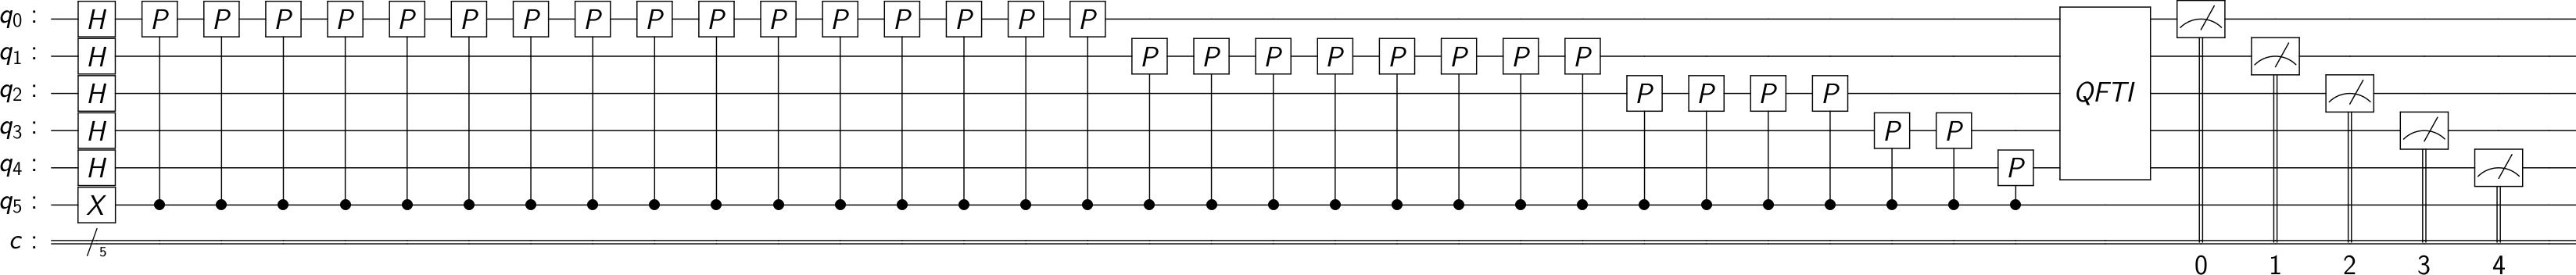

In [37]:
def qpe_program(n, theta):
    
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)
    
    # Initialize the qubits
    initialize_qubits(qc, range(n), n)
    
    # Apply the controlled unitary operators in sequence
    for x in range(n):
        exponent = 2**(n-x-1)
        unitary_operator_exponent(qc, x, n, theta, exponent)
        
    # Apply the inverse quantum Fourier transform
    apply_iqft(qc, range(n), n)
    
    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

n = 5; theta = 0.5
mycircuit = qpe_program(n, theta)
mycircuit.draw(output='latex')

That's it! You might find it useful to run your quantum circuit and see the measurement outcomes, as well as visualize the statevector at the end.

In order to run your quantum circuit and get the measurement outcomes, you simply need to run `Qiskit`'s `execute` function as follows.

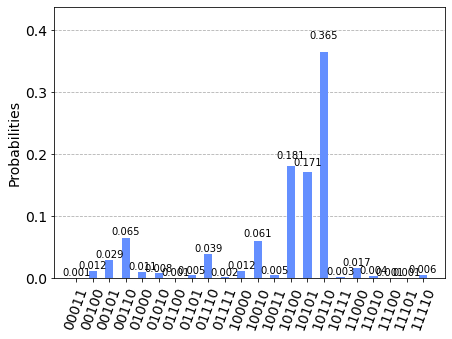

In [38]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

You can use the measured counts to determine $\theta$ using the following lines of code. Here, we are looking for the outcome with the largest probability, and dividing by $2^n$ since the quantum phase estimation algorithm outputs $2^n\theta$. Note also that we are reversing the order of the bits in the outcome, since `Qiskit` uses the top-most outcome bit to come from the top-most qubit.

In [39]:
import operator
highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
measured_theta = int(highest_probability_outcome, 2)/2**n
print("Using %d qubits with theta = %.2f, measured_theta = %.2f." % (n, theta, measured_theta))

Using 5 qubits with theta = 0.50, measured_theta = 0.41.
